# Import necessary libraries

In [96]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests
import datetime
import seaborn as sns
import IPython
import IPython.display

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# Get data from frost API and strømprisen API

In [16]:
FROM_DATE = datetime.date(2021, 12, 1)
TO_DATE = datetime.date(2023, 4, 1)

FROST_CLIENT_ID = ""
with open("frost_client_id") as f:
    line = f.readline().strip()
    if line[0] == "#":
        print("Add your Frost API Client ID to file `frost_client_id`\n")
        exit(1)

    FROST_CLIENT_ID = line

### Frost API

In [21]:
def get_data_from_frost():
    # TODO: Find the closest stations for each region's waterplants from: https://www.nve.no/energi/energisystem/vannkraft/vannkraftdatabase/
    stations = {
        "oest-norge": "SN18700",  # oslo, blindern
        "vest-norge": "",  # bergen
        "soer-norge": "",  # kristiansand
        "midt-norge": "",  # trondheim
        "nord-norge": "",  # troms
    }

    endpoint = "https://frost.met.no/observations/v0.jsonld?timeresolutions=PT1H"
    parameters = {
        "sources": stations["oest-norge"],
        "elements": "air_temperature,wind_from_direction,wind_speed,sum(precipitation_amount PT1H)",
        "referencetime": f"{FROM_DATE.strftime('%Y-%m-%d')}/{TO_DATE.strftime('%Y-%m-%d')}",
    }

    print("Fetching data from frost.met.no...")

    r = requests.get(endpoint, parameters, auth=(FROST_CLIENT_ID, ""))
    json = r.json()

    data = []
    if r.status_code == 200:
        data = json["data"]
        print("Data retrieved from frost.met.no!")
    else:
        print("Error! Returned status code %s" % r.status_code)
        print("Message: %s" % json["error"]["message"])
        print("Reason: %s" % json["error"]["reason"])
        print("Shutting down now, try agin!")
        return

    print("Creating DataFrame...")
    df = pd.DataFrame()
    for i in range(len(data)):
        row = pd.DataFrame()  # data[i]["observations"]
        for attr in data[i]["observations"]:
            name = f"{attr['elementId']}({attr['unit']})"
            row[name] = [attr["value"]]

        row["timestamp"] = pd.to_datetime(data[i]["referenceTime"])

        df = pd.concat([df, row], ignore_index=True)

    # convert timestamp to local time
    df["timestamp"] = df["timestamp"].dt.tz_convert("Europe/Oslo")
    df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S")

    # rename columns
    df.rename(
        columns={
            "air_temperature(degC)": "T (degC)",
            "wind_from_direction(degrees)": "wd (deg)",
            "wind_speed(m/s)": "wv (m/s)",
            "sum(precipitation_amount PT1H)(mm)": "rain (mm)",
        }, inplace=True
    )

    print("Finished creating DataFrame for frost.met.no!")

    return df


In [22]:
df1 = get_data_from_frost()
df1

Fetching data from frost.met.no...
Data retrieved from frost.met.no!
Creating DataFrame...
Finished creating DataFrame for frost.met.no!


,T (degC),wd (deg),wv (m/s),rain (mm),timestamp
0,-9.9,38,2.9,0.0,2021-12-01T01:00:00
1,-10.7,30,1.9,0.0,2021-12-01T02:00:00
2,-9.7,32,2.3,0.0,2021-12-01T03:00:00
3,-9.4,37,2.1,0.0,2021-12-01T04:00:00
4,-10.9,316,1.5,0.0,2021-12-01T05:00:00
...,...,...,...,...,...
11659,1.1,29,3.0,0.0,2023-03-31T21:00:00
11660,0.5,30,3.1,0.0,2023-03-31T22:00:00
11661,-0.4,30,3.1,0.0,2023-03-31T23:00:00
11662,-0.5,25,3.7,0.0,2023-04-01T00:00:00


### Strømpris API

In [25]:
def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)


def get_data_from_stroempris():
    print("Fething data from www.hvakosterstrommen.no...")
    r = requests.get(
        f"https://www.hvakosterstrommen.no/api/v1/prices/{TO_DATE.strftime('%Y/%m-%d')}_NO1.json"
    )

    if r.status_code == 200:
        print("Data retrieved from www.hvakosterstrommen.no!")
    else:
        print("Error! Returned status code %s" % r.status_code)
        print("Could not get today's electric prices from www.hvakosterstrommen.no")
        print("Shutting down now, try agin!")
        return

    print("Creating DataFrame...")

    df = pd.DataFrame()
    for d in date_range(FROM_DATE, TO_DATE):
        r = requests.get(
            f"https://www.hvakosterstrommen.no/api/v1/prices/{d.strftime('%Y/%m-%d')}_NO1.json"
        )

        if r.status_code != 200:
            print("Error! Returned status code %s" % r.status_code)
            print(
                f"Could not get prices from www.hvakosterstrommen.no ({d.strftime('%Y-%m-%d')})"
            )
            print("Shutting down now, try agin!")
            return

        raw_data = r.json()
        dataset = pd.DataFrame.from_dict(raw_data)
        dataset["time_start"] = pd.to_datetime(
            dataset["time_start"], format="%Y-%m-%dT%H:%M:%S", utc=True
        )
        dataset["time_start"] = dataset["time_start"].dt.tz_convert("Europe/Oslo")
        dataset["time_start"] = dataset["time_start"].dt.strftime("%Y-%m-%dT%H:%M:%S")

        df = pd.concat([df, dataset], ignore_index=True)

    df = df.drop(columns=["EUR_per_kWh", "EXR", "time_end"])

    print("Finished creating DataFrame for www.hvakosterstrommen.no!")

    return df


In [26]:
df2 = get_data_from_stroempris()
df2

Fething data from www.hvakosterstrommen.no...
Data retrieved from www.hvakosterstrommen.no!
Creating DataFrame...
Finished creating DataFrame for www.hvakosterstrommen.no!


,price (NOK/kWh),timestamp
0,1.30043,2021-12-01T00:00:00
1,1.12077,2021-12-01T01:00:00
2,1.02818,2021-12-01T02:00:00
3,0.99119,2021-12-01T03:00:00
4,0.99068,2021-12-01T04:00:00
...,...,...
11658,1.18181,2023-03-31T19:00:00
11659,1.15096,2023-03-31T20:00:00
11660,1.07863,2023-03-31T21:00:00
11661,1.01060,2023-03-31T22:00:00


### Extract to csv

In [1]:
df = pd.merge(df1, df2, how="inner", on="timestamp")
#$df = df[["UTC time", "temperature", "NOK_per_kWh", "region"]]
df.set_index("timestamp", inplace=True)
df.to_csv("data.csv", sep="\t")
df

NameError: name 'pd' is not defined

# Forecast

### Import data from a csv

In [48]:
# import data from csv and extract it to a dataframe
df = pd.read_csv("./data.csv", sep="\t")
date_time = pd.to_datetime(df.pop("timestamp"), format="%Y-%m-%dT%H:%M:%S")
df.head()

,T (degC),wd (deg),wv (m/s),rain (mm),price (NOK/kWh)
0,-9.9,38,2.9,0.0,1.12077
1,-10.7,30,1.9,0.0,1.02818
2,-9.7,32,2.3,0.0,0.99119
3,-9.4,37,2.1,0.0,0.99068
4,-10.9,316,1.5,0.0,1.13549


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
T (degC),11664.0,5.612894,8.151379,-14.40000,-0.400000,3.900000,12.000000,28.50000
wd (deg),11664.0,139.534636,106.456754,0.00000,34.000000,152.000000,220.000000,360.00000
wv (m/s),11664.0,2.544059,1.562049,0.00000,1.300000,2.200000,3.500000,10.50000
rain (mm),11664.0,0.081756,0.401365,0.00000,0.000000,0.000000,0.000000,13.80000
price (NOK/kWh),11664.0,1.786878,1.020942,0.00041,1.198045,1.567975,1.968495,7.80395


Text(0, 0.5, 'Wind Velocity [m/s]')

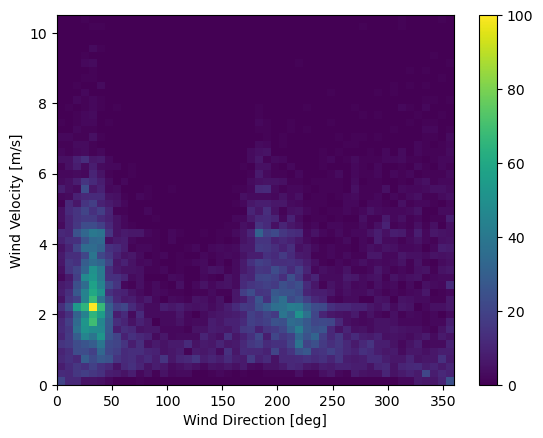

In [5]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=100)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')


In [49]:
# convert vind direction and speed into wind vector

wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

(-7.889173324561134, 10.397814721786487, -10.06156645072663, 6.389385945454136)

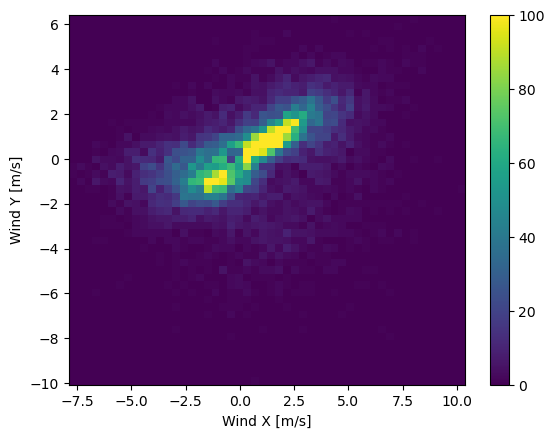

In [93]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=100)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [50]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [51]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

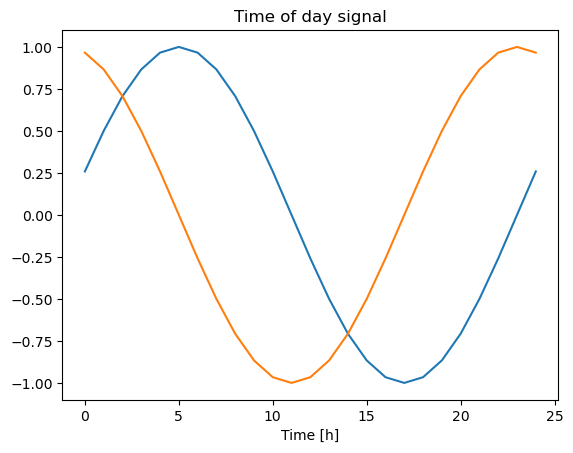

In [52]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')


In [53]:
df["price (NOK/kWh)"] = df["price (NOK/kWh)"].apply(lambda x: round(x, 2))
df.head()

,T (degC),rain (mm),price (NOK/kWh),Wx,Wy,Day sin,Day cos,Year sin,Year cos
0,-9.9,0.0,1.12,2.285231,1.785418,0.258819,0.965926,-0.501957,0.864892
1,-10.7,0.0,1.03,1.645448,0.950000,0.500000,0.866025,-0.501337,0.865252
2,-9.7,0.0,0.99,1.950511,1.218814,0.707107,0.707107,-0.500717,0.865611
3,-9.4,0.0,0.99,1.677135,1.263812,0.866025,0.500000,-0.500096,0.865970
4,-10.9,0.0,1.14,1.079010,-1.041988,0.965926,0.258819,-0.499475,0.866328


In [54]:
df['lag price'] = df['price (NOK/kWh)'].shift(1)
df.dropna(inplace=True)
df.head()

,T (degC),rain (mm),price (NOK/kWh),Wx,Wy,Day sin,Day cos,Year sin,Year cos,lag price
1,-10.7,0.0,1.03,1.645448,0.950000,0.500000,8.660254e-01,-0.501337,0.865252,1.12
2,-9.7,0.0,0.99,1.950511,1.218814,0.707107,7.071068e-01,-0.500717,0.865611,1.03
3,-9.4,0.0,0.99,1.677135,1.263812,0.866025,5.000000e-01,-0.500096,0.865970,0.99
4,-10.9,0.0,1.14,1.079010,-1.041988,0.965926,2.588190e-01,-0.499475,0.866328,0.99
5,-11.2,0.0,1.22,1.438070,0.701394,1.000000,1.350310e-11,-0.498854,0.866686,1.14


### Splitting data

In [82]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.7):int(n*0.9)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

In [83]:
train_price = train_df.pop("price (NOK/kWh)")
val_price = val_df.pop("price (NOK/kWh)")
test_price = test_df.pop("price (NOK/kWh)")

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df["price (NOK/kWh)"] = train_price
val_df["price (NOK/kWh)"] = val_price
test_df["price (NOK/kWh)"] = test_price

train_df.tail()

,T (degC),rain (mm),Wx,Wy,Day sin,Day cos,Year sin,Year cos,lag price,price (NOK/kWh)
9326,-2.212536,-0.179253,-0.030825,0.384564,-0.366772,-1.365407,-0.153572,1.296728,-0.332465,1.59
9327,-2.151841,-0.179253,0.249867,0.538064,-0.707838,-1.224135,-0.152541,1.296852,-0.323196,1.63
9328,-2.188258,-0.179253,-0.342911,0.306386,-1.000718,-0.999404,-0.151511,1.296976,-0.286117,1.71
9329,-2.297509,-0.179253,-0.046560,0.264654,-1.225452,-0.706529,-0.150480,1.297099,-0.211960,1.75
9330,-2.321786,-0.179253,0.333562,0.667804,-1.366726,-0.365468,-0.149450,1.297221,-0.174881,1.75


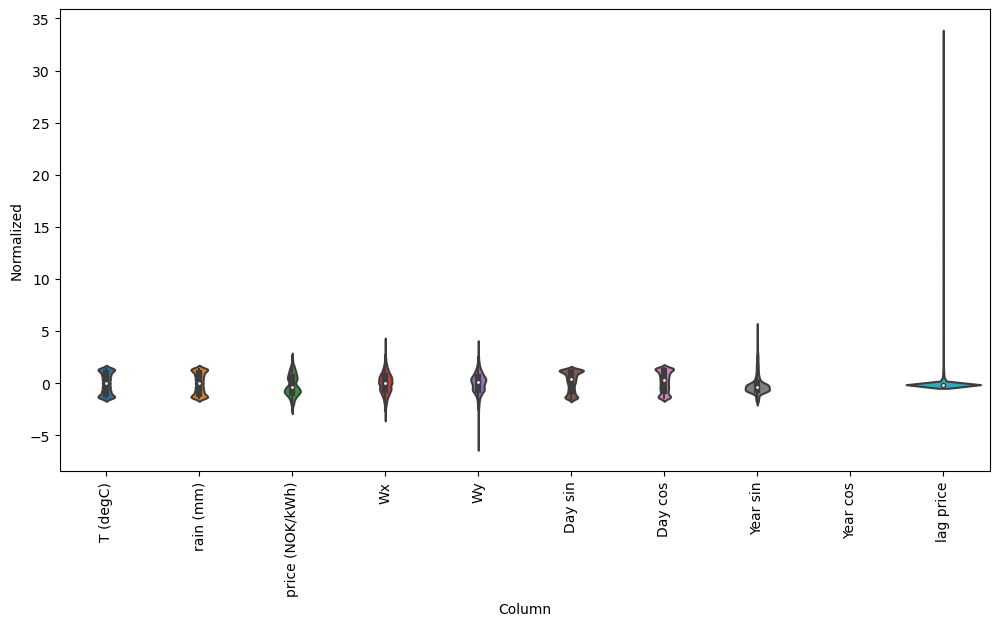

In [84]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [86]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col="price (NOK/kWh)", max_subplots=3):
        """
        Plots the input and label data for a given column, with optional predictions
        from a machine learning model.

        Parameters:
        -----------
        model : optional
            A machine learning model used to generate predictions. Default is None.
        plot_col : str
            The name of the column to plot. Default is "price (NOK/kWh)".
        max_subplots : int
            The maximum number of subplots to display. Default is 3.
        """
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


In [87]:
def compile_and_fit(model, window, patience=2, max_epochs=20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 168
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167]
Label column name(s): None

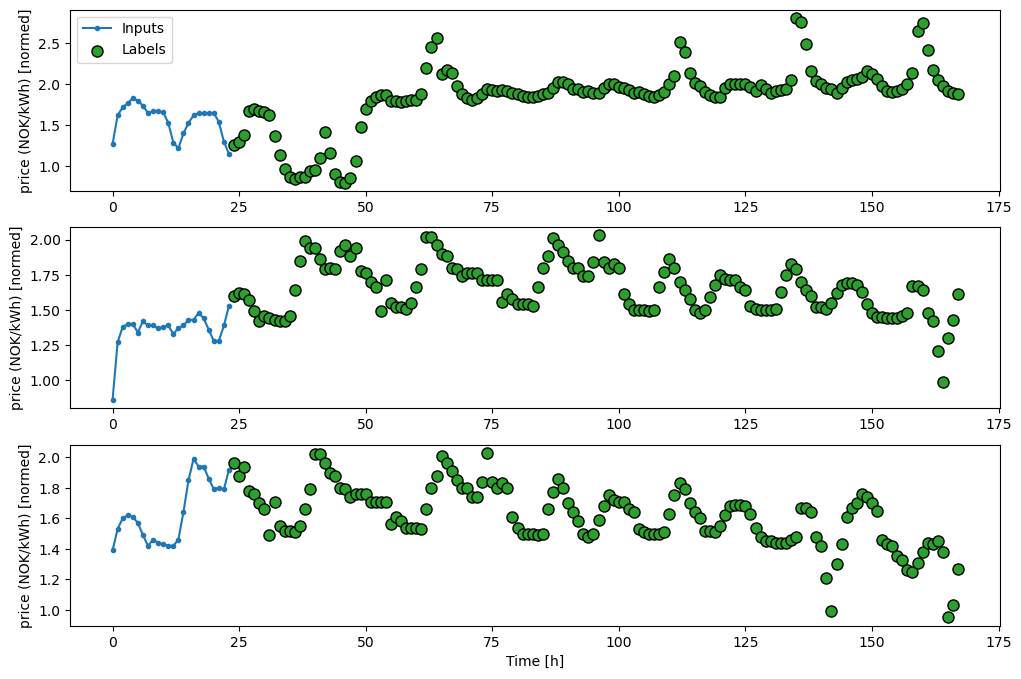

In [88]:
OUT_STEPS = 24*6
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baseline

68/68 [==============================] - 0s 632us/step - loss: 0.9232 - mean_absolute_error: 0.5803


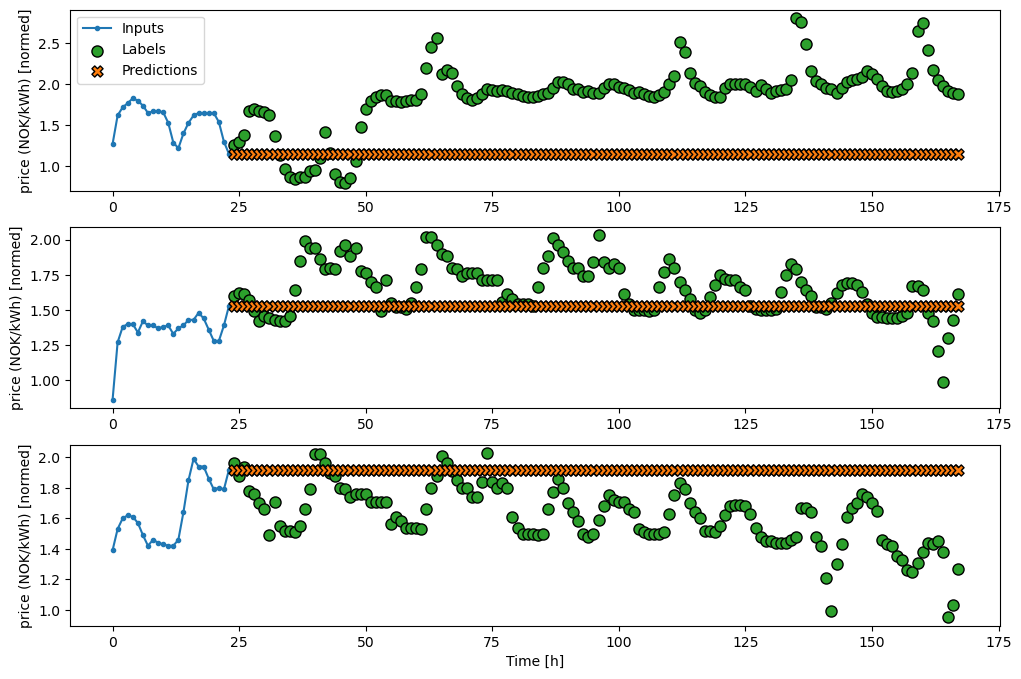

In [89]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

## Linear regression

68/68 [==============================] - 0s 812us/step - loss: 0.2867 - mean_absolute_error: 0.2638


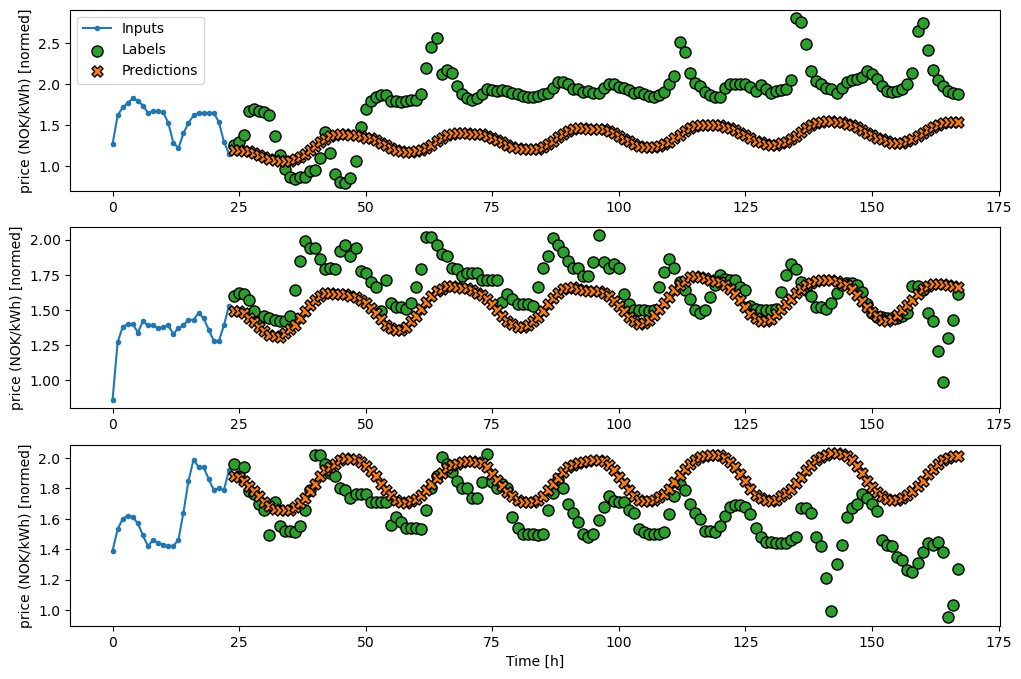

In [97]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

linear_history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## Dense neural network

68/68 [==============================] - 0s 2ms/step - loss: 0.2925 - mean_absolute_error: 0.2797


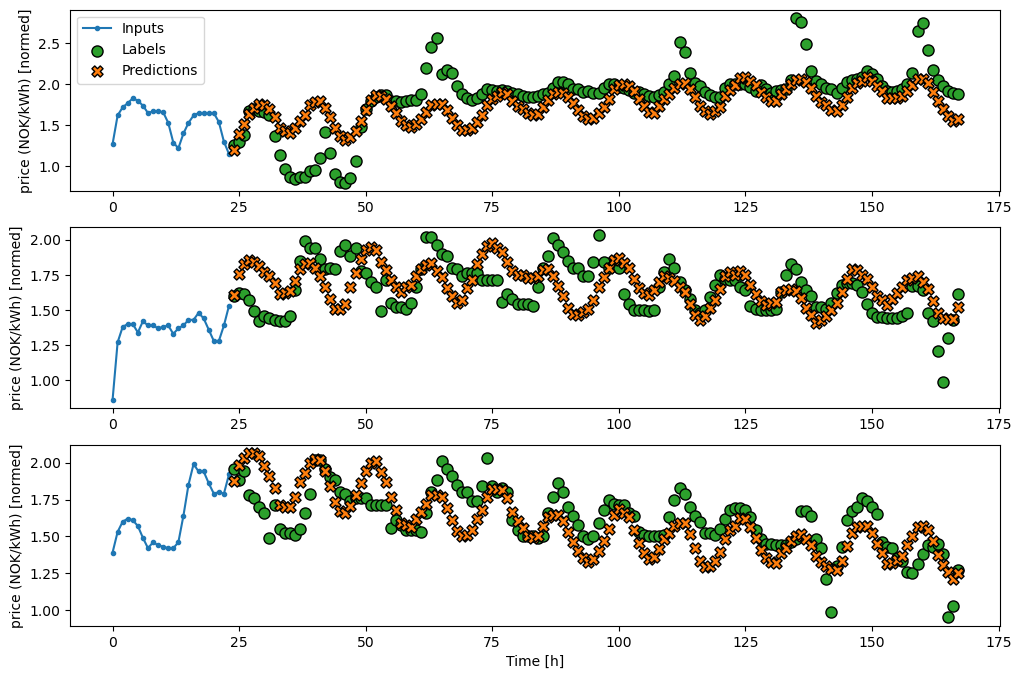

In [98]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

dense_history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

68/68 [==============================] - 0s 1ms/step - loss: 0.2962 - mean_absolute_error: 0.2880


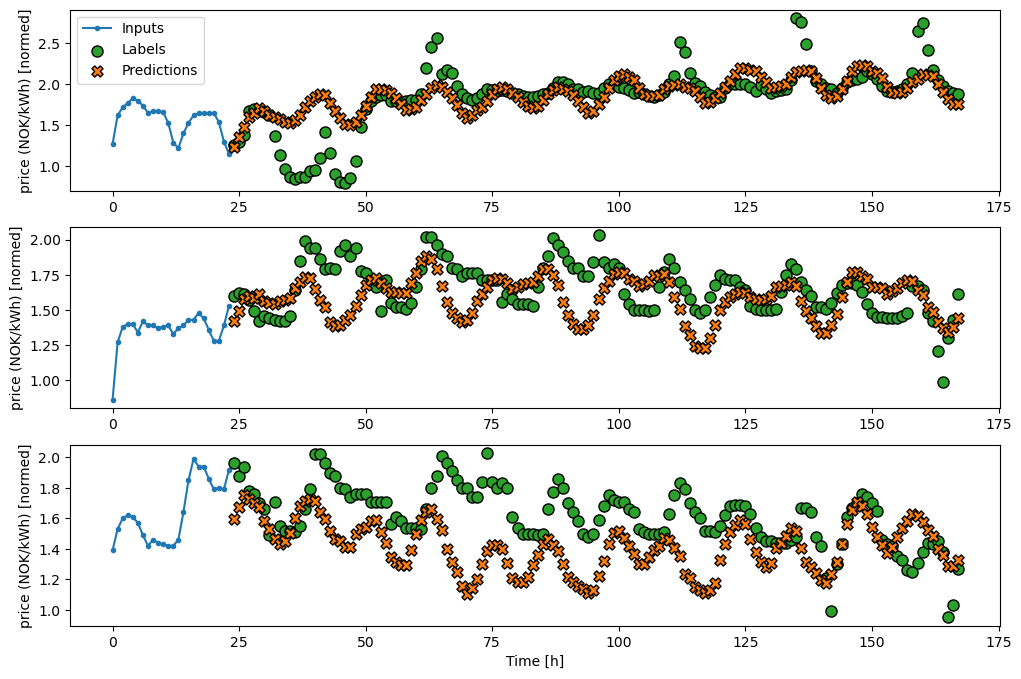

In [99]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

conv_history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


68/68 [==============================] - 0s 2ms/step - loss: 0.3001 - mean_absolute_error: 0.2999


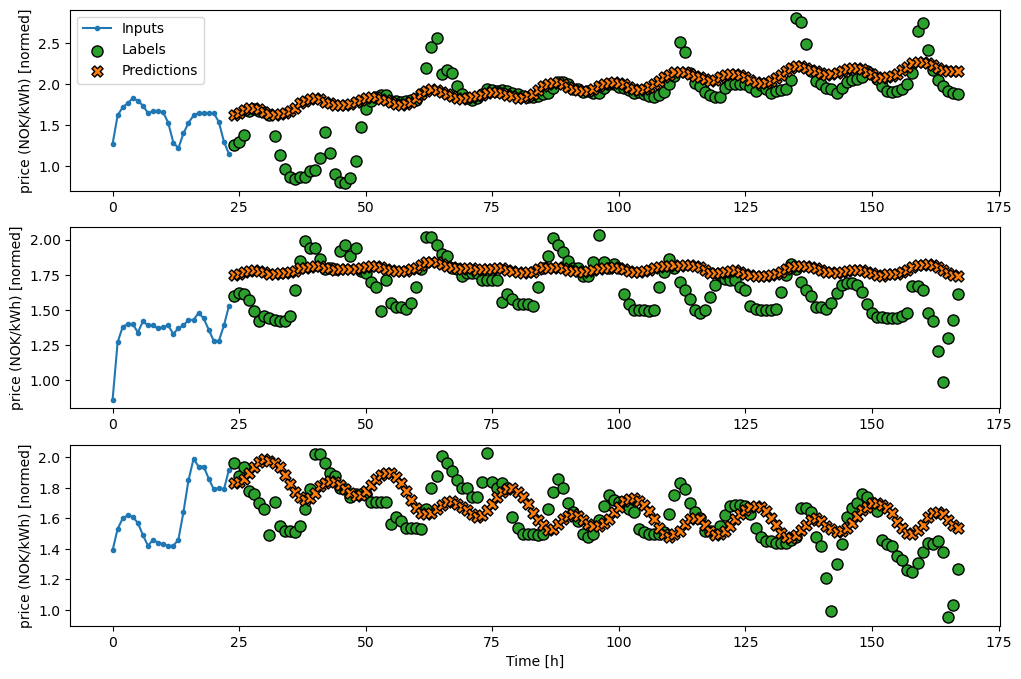

In [100]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

lstm_history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [94]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5808
Linear  : 0.3469
Dense   : 0.4134
Conv    : 0.4675
LSTM    : 0.5893


In [106]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(multi_linear_model)
tflite_model = converter.convert()

# Save the model.
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp8y887tn_/assets


INFO:tensorflow:Assets written to: /tmp/tmp8y887tn_/assets
